[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/SilverViking/deep-learning-biology/blob/main/exercises/assignments/2020-dlb-2-cnn-classification.ipynb)

# Exercise 2: Convolutional Neural Networks for Classification

In this notebook, we will be using convolutional neural networks (CNN) to classify optical coherence tomography images for age-related macular degeneration and diabetic macular edema. 

The structure of these exercises is as follows: 
1. [Import libraries and download data](#scrollTo=Im6B91nkXCuW)
2. [Data loading and augmentation](#scrollTo=P03i-jLJZQSy)
3. [Training a CNN from scratch](#scrollTo=N_p6H2uV3vsn)
4. [Visualizing the training progress with Tensorboard](#scrollTo=O_N-2Asp0RFp)
5. [Finetuning a pre-trained CNN](#scrollTo=hCfqPkf27lMK)

This notebook is largely based on the research published in: 

Kermany, D. S., Goldbaum, M., Cai, W., Valentim, C. C. S., Liang, H., Baxter, S. L., McKeown, A., Yang, G., Wu, X., Yan, F., Dong, J., Prasadha, M. K., Pei, J., Ting, M., Zhu, J., Li, C., Hewett, S., Dong, J., Ziyar, I., … Zhang, K. (2018). Identifying Medical Diagnoses and Treatable Diseases by Image-Based Deep Learning. Cell, 172(5), 1122-1131.e9. https://doi.org/10.1016/j.cell.2018.02.010

## 1. Import libraries and download data
As usual, we import the necessary libraries and download the required data. 

In [1]:
import numpy as np
import os
from collections import OrderedDict
import matplotlib.pyplot as plt
plt.rcdefaults()
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets
from torchvision.transforms import Compose, RandomRotation, RandomHorizontalFlip, ToTensor, Normalize
import torchvision.models as models
import gdown
import zipfile
from PIL import Image
import progressbar

As you will notice, Colab environments come with quite a large library pre-installed. If you need to import a module that is not yet specified, you can add it in the previous cell (make sure to run it again). If the module is not installed, you can install it with `pip`. 

To make your work reproducible, it is advised to initialize all modules with stochastic functionality with a fixed seed. Re-running this script should give the same results as long as the seed is fixed. 

In [2]:
# make sure the results are reproducible
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# run all computations on the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Running computations with %s' % torch.device(device))
if torch.cuda.is_available():
    print(torch.cuda.get_device_properties(device))

Running computations with cuda
_CudaDeviceProperties(name='GeForce GTX 960M', major=5, minor=0, total_memory=2048MB, multi_processor_count=5)


We will now download the required data from a public Google Drive repository. The data is stored as a zip archive and automatically extracted to the `data` directory in the current directory. 

Note that, for the sake of practicality in this workshop, we have only provided a fraction of the full dataset (approximately 15% of the complete dataset). This is due to disk limitations on Google Colab, but perhaps mostly to limit the computational bottleneck. Feel free to test this approach on the complete dataset (available here) on an alternative compute environment! 

In [3]:
# fields
url = 'http://data.bits.vib.be/pub/trainingen/DeepLearning/data-2.zip'
cmp_data_path = 'data.zip'

# download the compressed data
gdown.download(url, cmp_data_path, quiet=False)

# extract the data
zip = zipfile.ZipFile(cmp_data_path)
zip.extractall('')

# remove the compressed data
#os.remove(cmp_data_path)

Downloading...
From: http://data.bits.vib.be/pub/trainingen/DeepLearning/data-2.zip
To: E:\git\deep-learning-biology\exercises\assignments\data.zip
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 963M/963M [00:27<00:00, 35.6MB/s]


## 2. Data loading and augmentation

Let's visualize an image of each class in the training data. 

Class CNV has 2000 images
Class DME has 1000 images
Class DRUSEN has 1000 images
Class NORMAL has 10000 images


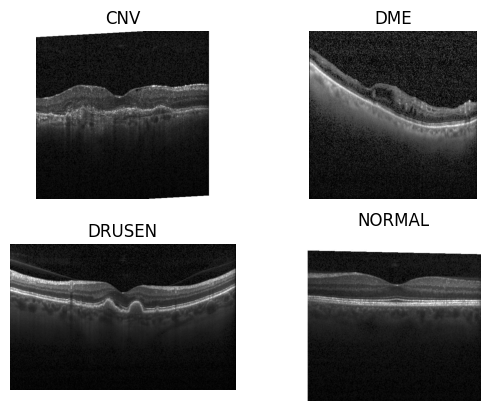

In [4]:
# list of the classes
classes = ['CNV', 'DME', 'DRUSEN', 'NORMAL']
class_distribution = np.zeros((4,))
for i, c in enumerate(classes):

  # get a list of all files in this class directory
  files = os.listdir(os.path.join('data-2/OCT/train', c))

  # get a random sample
  filename = files[np.random.randint(len(files))]

  # print stats
  class_distribution[i] = len(files)
  print('Class %s has %d images' % (c, len(files)))

  # load the image
  image = Image.open(os.path.join(os.path.join('data-2/OCT/train', c, filename)))

  # show the image
  plt.subplot(2, 2, i + 1)
  plt.imshow(image, cmap='gray')
  plt.axis('off')
  plt.title(c)

plt.show()

For most machine learning applications, normalization is a valuable pre-processing step. Fortunately, this can be easily done in PyTorch through dataloaders. You might have noticed that a very simple dataloader was already implemented in the previous exercises. Now, you will implement this yourself! 

A dataloader instance uses a dataset to sample batches that can be used for training and testing. Additionally, dataloaders allow very efficient usage of so-called data augmentation. This is a way of generating more labeled data using transformations such as rotations, scaling, shifts, etc. so that the model generalizes better. Labeled data is typically hard to obtain due to the fact that labels are expensive or time-consuming to generate. This is especially the case in the biomedical domain where often also expertise is required. As a consequence, models often overfit on the training data itself. To improve generalization, it is common practice to apply data augmentation, i.e. transform the data in a way that do not change the labels. Typical transformations are rotations, mirroring, scaling, random deformations, etc. 

A dataset class should implement two functions: a `__getitem__` function that selects the $i$th instance and a `__len__` function that returns the amount of samples in the dataset. 

**Exercise**: Implement the `MedicalDataset` class: 
- The `__init__` function has already been implemented and loads the train/test data from a specific directory. The data are stored in `MedicalDataset.data`, which is a list of [Pillow Image](https://pillow.readthedocs.io/en/stable/reference/Image.html) objects. The corresponding labels are stored in `MedicalDataset.labels`, which is a list of integer labels. Note that the data is resized to 64 x 64 pixel images. This is for computational convenience, you can later increase this to the original size and analyze the results. 
- Implement the `__getitem__` function: this should return the $i$th image and its corresponding label als a tuple. 
- Implement the `__len__` function: this should return the amount of samples in the dataset. 
- Include data augmentation while sampling from the dataset, i.e. in the `__getitem__` function. You can apply small [rotations](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.RandomRotation) and [horizontal flips](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.RandomHorizontalFlip) on the data. Note that you can deal with any kind of pre-processing problem here. For example, the should be [normalized](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Normalize) and [converted to PyTorch tensors](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.ToTensor). The mean and standard deviation of the instensity values is approximately 0.1706 and 0.1841. Make sure you [compose](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Compose) these augmentations in the right order! 


In [5]:

# implementation of a dataset that will be used for training
class MedicalDataset(data.Dataset):

  def __init__(self, top_dir, augmenter=None, input_shape=(256, 256)):
    
    # useful fields
    self.top_dir = top_dir
    self.classes = ['CNV', 'DME', 'DRUSEN', 'NORMAL']
    self.input_shape = input_shape
    self.augmenter = augmenter

    # logging
    print('Start loading %s' % self.top_dir)

    # load the data
    self.data = []
    self.labels = []
    for i, c in enumerate(classes):

      # get a list of all files in this class directory
      files = os.listdir(os.path.join(top_dir, c))

      # logging
      print('  Loading class %s' % c)

      # load all files
      for filename in files:

        # load image
        x = Image.open(os.path.join(os.path.join(top_dir, c, filename)))

        # save as 8-bit gray scale images
        x = x.convert(mode='L')

        # resize images for memory limitations
        x = x.resize(input_shape)

        # save the image and corresponding label
        self.data.append(x)
        self.labels.append(i)
  
  def __getitem__(self, i):
    """
    INSERT CODE HERE
    """
    x = self.data[i]
    y = self.labels[i]
    if self.augmenter is not None:
        x = self.augmenter(x)
    return x, y
  
  def __len__(self):
    """
    INSERT CODE HERE
    """
    return len(self.data)

# fixed input shape for the network
input_shape = (64, 64)

# define the data augmenter
augmenter_train = Compose([RandomRotation(20), RandomHorizontalFlip(), ToTensor(), Normalize(0.1706, 0.1841)])
augmenter_test = Compose([ToTensor(), Normalize(0.1706, 0.1841)])

# make an instance of the dataset for training and testing
ds_train = MedicalDataset('data-2/OCT/train', augmenter=augmenter_train, input_shape=input_shape)
ds_test = MedicalDataset('data-2/OCT/test', augmenter=augmenter_test, input_shape=input_shape)

Start loading data-2/OCT/train
  Loading class CNV
  Loading class DME
  Loading class DRUSEN
  Loading class NORMAL
Start loading data-2/OCT/test
  Loading class CNV
  Loading class DME
  Loading class DRUSEN
  Loading class NORMAL


Extracting labeled samples now becomes very easy! 

There are 14000 training samples
There are 1000 testing samples
The selected sample is [1, 64, 64] dimensional


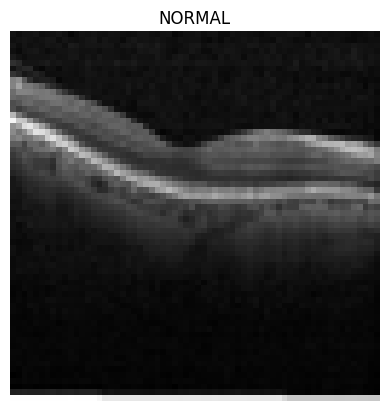

In [6]:
# extract a labeled sample
print('There are %d training samples' % len(ds_train))
print('There are %d testing samples' % len(ds_test))
n = np.random.randint(len(ds_test))
x, y = ds_test[n]
print('The selected sample is %s dimensional' % list(x.size()))
plt.imshow(x[0], cmap='gray')
plt.axis('off')
plt.title(classes[y])
plt.show()

This is a quick illustration of the data augmentation. 

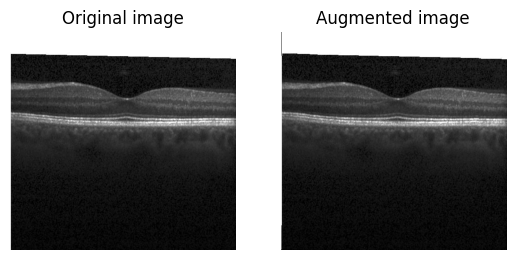

In [7]:
# apply augmentation on a random sample
image_ = augmenter_train(image)

# show images
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.title('Original image')
plt.subplot(1, 2, 2)
plt.imshow(image_[0], cmap='gray')
plt.axis('off')
plt.title('Augmented image')
plt.show()

Great, now the only thing we have to do in order to handle batching is to wrap the dataset in a dataloader object that specifies the desired batch size! 

In [8]:
# desired batch size
batch_size = 64

train_loader = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(ds_test, batch_size=batch_size)

## 3. Training a CNN from scratch

Not that we have dealt with data loading and augmentation, we are ready to define a network architecture. 

**Exercise**: Implement the `MedicalNet` class: 
- Similar to the previous exercise, a Module extension should have an initialization and a forward propagation function (respectively `__init__` and `forward`). The initialization function should initialize the required convolutional layers, activation functions, batch normalization, etc. 
- Construct a CNN with 6 [convolutional layers](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d) (you can choose a fixed amount of feature maps). Each convolutional layer should be followed by a [batch normalization](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html#torch.nn.BatchNorm2d), [ReLU activation](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU) and [max pooling](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d) layer. The final features then have to be [flattened](https://pytorch.org/docs/stable/tensors.html#torch.Tensor.view) and propagated to a [linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear) (fully connected) layer that generates the logits. 

In [17]:
class MedicalNet(nn.Module):
    def __init__(self, feature_maps=16):
        super(MedicalNet, self).__init__()
        """
        INSERT CODE HERE
        """
        kernel_size = 3
        self.conv1 = nn.Conv2d(           1, feature_maps, kernel_size)
        self.conv2 = nn.Conv2d(feature_maps, feature_maps, kernel_size)
        self.conv3 = nn.Conv2d(feature_maps, feature_maps, kernel_size)
        self.conv4 = nn.Conv2d(feature_maps, feature_maps, kernel_size)
        self.conv5 = nn.Conv2d(feature_maps, feature_maps, kernel_size)
        self.conv6 = nn.Conv2d(feature_maps, feature_maps, kernel_size)
        
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.relu3 = nn.ReLU()
        self.relu4 = nn.ReLU()
        self.relu5 = nn.ReLU()
        self.relu6 = nn.ReLU()

        self.norm1 = nn.BatchNorm2d(feature_maps)
        self.norm2 = nn.BatchNorm2d(feature_maps)
        self.norm3 = nn.BatchNorm2d(feature_maps)
        self.norm4 = nn.BatchNorm2d(feature_maps)
        self.norm5 = nn.BatchNorm2d(feature_maps)
        self.norm6 = nn.BatchNorm2d(feature_maps)
        
        self.fc = nn.Linear(feature_maps, len(classes))

    def forward(self, x):
        """
        INSERT CODE HERE
        """
        kernel_size = (2, 2)
        x = F.MaxPool2d(self.relu1(self.norm1(self.conv1(x))), kernel_size)
        x = F.MaxPool2d(self.relu2(self.norm2(self.conv2(x))), kernel_size)
        x = F.MaxPool2d(self.relu3(self.norm3(self.conv3(x))), kernel_size)
        x = F.MaxPool2d(self.relu4(self.norm4(self.conv4(x))), kernel_size)
        x = F.MaxPool2d(self.relu5(self.norm5(self.conv5(x))), kernel_size)
        x = F.MaxPool2d(self.relu6(self.norm6(self.conv6(x))), kernel_size)
        x = F.flatten(x)  # or x.view(-1, feature_maps)
        x = fc(x)
        return x


net = MedicalNet(feature_maps=16)
print(net)

MedicalNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (relu1): ReLU()
  (relu2): ReLU()
  (relu3): ReLU()
  (relu4): ReLU()
  (relu5): ReLU()
  (relu6): ReLU()
  (norm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=T

Next, we need to define a loss function to train the classifier. Similar to the previous exercise, we employ the cross entropy function. More specifically, since the data is imbalanced, we will use the following weights to balance the class importances: 
$$
w_c=\frac{n}{\left| \left\{ i | y_i = c \right\} \right|}
$$
where $n$ is the amount of training samples. In other words, we employ the inverse class frequencies for weight balancing. For the optimization, we employ the Adam optimizer. 

In [18]:
learning_rate = 0.001
class_weights = torch.from_numpy(np.divide(1, class_distribution)).float().to(device)
class_weights = class_weights / class_weights.sum()
for i, c in enumerate(classes):
  print('Weight for class %s: %f' % (c, class_weights.cpu().numpy()[i]))

loss_fn = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

Weight for class CNV: 0.192308
Weight for class DME: 0.384615
Weight for class DRUSEN: 0.384615
Weight for class NORMAL: 0.038462


Now we can train the CNN with stochastic gradient descent. 

**Exercise**: Train the CNN for classification of the medical images: 
- Below is skeleton code that you might recognize from the previous exercise. Implement the missing code snippets to train the CNN. 
- Compute the accuracy of the classifier at the end of each test epoch. 
- Keep track of the best performing method (w.r.t. the test accuracy) and [save this model](https://pytorch.org/tutorials/beginner/saving_loading_models.html). The recommended way of doing this, is by using the [`torch.save`](https://pytorch.org/docs/stable/generated/torch.save.html#torch.save) function on the state dictionary of the network. 

In [19]:
state_dict = net.state_dict()
for k in state_dict.keys():
  print('Key: %s - Parameter shape: %s' % (k, state_dict[k].size()))

Key: conv1.weight - Parameter shape: torch.Size([16, 1, 3, 3])
Key: conv1.bias - Parameter shape: torch.Size([16])
Key: conv2.weight - Parameter shape: torch.Size([16, 16, 3, 3])
Key: conv2.bias - Parameter shape: torch.Size([16])
Key: conv3.weight - Parameter shape: torch.Size([16, 16, 3, 3])
Key: conv3.bias - Parameter shape: torch.Size([16])
Key: conv4.weight - Parameter shape: torch.Size([16, 16, 3, 3])
Key: conv4.bias - Parameter shape: torch.Size([16])
Key: conv5.weight - Parameter shape: torch.Size([16, 16, 3, 3])
Key: conv5.bias - Parameter shape: torch.Size([16])
Key: conv6.weight - Parameter shape: torch.Size([16, 16, 3, 3])
Key: conv6.bias - Parameter shape: torch.Size([16])
Key: norm1.weight - Parameter shape: torch.Size([16])
Key: norm1.bias - Parameter shape: torch.Size([16])
Key: norm1.running_mean - Parameter shape: torch.Size([16])
Key: norm1.running_var - Parameter shape: torch.Size([16])
Key: norm1.num_batches_tracked - Parameter shape: torch.Size([])
Key: norm2.weig

- This dictionary efficiently groups the parameters of the model together and gives the best guarantee that you will be able to load your custom network later. At the end of training, load the best performing network using [`torch.load`](https://pytorch.org/docs/stable/generated/torch.load.html#torch.load) and visualize the confusion matrix on the test data with the provided validation function. Note that `torch.load` loads a state dictionary, this is not yet a network module! You will have to call the [`load_state_dict`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.load_state_dict) method to load the parameters in the existing network instance. 



In [20]:
def validate_net(net, loader):
    
    # set the network in training mode
    net.eval()
    net.to(device)
    
    # keep track of the loss and predictions
    preds = np.zeros((len(loader.dataset), 4))
    
    for i, data in enumerate(loader): 
        
        # sample data
        x, y = data

        # transfer data to GPU and correct format
        x = x.float().to(device)
        
        # feed the batch to the network and compute the outputs
        y_pred = net(x)

        # get the class probability predictions and save them for validation
        y_ = torch.softmax(y_pred, dim=1)
        b = i * loader.batch_size
        preds[b: b + y_.size(0), :] = y_.detach().cpu().numpy()
    
    # compute accuracy
    y = np.array(loader.dataset.labels)
    acc = accuracy_score(y, preds.argmax(axis=1))
    print('Accuracy: %.1f' % (acc*100))
    conf_matrix = confusion_matrix(y, preds.argmax(axis=1), normalize='true')
    cm_display = ConfusionMatrixDisplay(conf_matrix, classes).plot()

# implementation of a single training epoch
def train_epoch(net, loader, loss_fn, optimizer):
    
    # set the network in training mode
    """
    INSERT CODE HERE
    """
    net.train()
    
    # keep track of the loss
    loss_cum = 0
    cnt = 0
    
    bar = progressbar.ProgressBar(max_value=len(loader.dataset))
    for i, data in enumerate(loader): 
        # update progressbar
        bar.update(i * loader.batch_size)
        
        # sample data
        """
        INSERT CODE HERE
        """
        x, y = data   # note: x and y are a *batch* of samples
#         print(type(x))
#         print(type(y))
#         print(x)
#         print(y)

        # transfer data to GPU and correct format
        """
        INSERT CODE HERE
        """
        x = x.float().to(device)
        y = y.long().to(device)
        
        # set all gradients equal to zero
        """
        INSERT CODE HERE
        """
        net.zero_grad()
        
        # feed the batch to the network and compute the outputs
        """
        INSERT CODE HERE
        """
        y_pred = net(x)
        
        # compare the outputs to the labels with the loss function
        loss = loss_fn(y_pred, y)
        loss_cum += loss.data.cpu().numpy()
        cnt += 1
        
        # backpropagate the gradients w.r.t. computed loss
        """
        INSERT CODE HERE
        """
        loss.backward()

        # apply one step in the optimization
        """
        INSERT CODE HERE
        """
        optimizer.step()
    
    # compute the average loss
    loss_avg = loss_cum / cnt
    
    return loss_avg

# implementation of a single testing epoch
def test_epoch(net, loader, loss_fn):
    
    # set the network in training mode
    """
    INSERT CODE HERE
    """
    net.eval()
    
    # keep track of the loss and predictions
    preds = np.zeros((len(loader.dataset), 4))
    loss_cum = 0
    cnt = 0
    
    for i, data in enumerate(loader): 
        
        # sample data
        """
        INSERT CODE HERE
        """
        x, y = data  # x and y are a *batch* of samples

        # transfer data to GPU and correct format
        """
        INSERT CODE HERE
        """
        x = x.float().to(device)
        y = y.long().to(device)
        
        # feed the batch to the network and compute the outputs
        """
        INSERT CODE HERE
        """
        y_pred = net(x)
        
        # compare the outputs to the labels with the loss function
        loss = loss_fn(y_pred, y)
        loss_cum += loss.data.cpu().numpy()
        cnt += 1

        # get the class probability predictions and save them for validation
        """
        INSERT CODE HERE
        """
        probs = F.softmax(y_pred, dim=1)  # TODO: try without dim and check error msg
        idx = i * loader.batch_size
        preds[idx : idx + x.shape[0], :] = probs  # FIXME
    
    # compute accuracy
    """
    INSERT CODE HERE
    """
    y = np.array(loader.dataset.labels)
    acc = accuracy_score(y, preds.argmax(axis=1))
    
    # compute the average loss
    loss_avg = loss_cum / cnt
    
    return loss_avg, acc

def train_net(net, train_loader, test_loader, loss_fn, optimizer, epochs, log_dir):
    
    # transfer the network to the GPU
    net.cuda()
    
    best_acc = 0
    for epoch in range(epochs):
        
        # training
        train_loss = train_epoch(net, train_loader, loss_fn, optimizer)
        
        # testing
        test_loss, acc = test_epoch(net, test_loader, loss_fn)

        # check if accuracy has increased
        if acc > best_acc: 
            best_acc = acc

            # save the model
            torch.save(net.state_dict(), 'medicalnet_best.cpt')
        
        print('Epoch %5d - Train loss: %.6f - Test loss: %.6f' % (epoch, train_loss, test_loss))

# parameters
n_epochs = 10
log_dir = '.'

# start training
train_net(net, train_loader, test_loader, loss_fn, optimizer, n_epochs, log_dir)

# load the best parameters
state_dict = torch.load('medicalnet_best.cpt')
net.load_state_dict(state_dict)

# validate with confusion plot
validate_net(net, test_loader)

N/A% (0 of 14000) |                      | Elapsed Time: 0:00:00 ETA:  --:--:--

AttributeError: module 'torch.nn.functional' has no attribute 'MaxPool2d'

## 4. Visualizing the training progress with TensorBoard

Debugging CNNs can be tricky, because they are essentially black boxes and it is difficult for us to find out what they are exactly doing during training. To simplify training for developers, researchers at Google have developed TensorBoard. Even though this is a platform embedded in TensorFlow, an alternative to PyTorch, it is perfectly possible to use the tool to aid training visualization. 

TensorBoard uses a binary .events file to save training logs such as scalars, images, histograms, etc. This file is continuesly read, parsed and visualized in the TensorBoard UI. To launch TensorBoard in a Colab notebook, you first have to load the extension and run the executable with the logging directory that contains this .events file as an argument. Note that you will not have to load the tensorboard extension on your local workstation. If you have correctly installed TensorBoard, the executable should be within reach in your local environment.  

In [ ]:
# load the extension
%load_ext tensorboard

In [ ]:
# launch tensorboard
%tensorboard --logdir .

Obviously, as we have not yet written any data to the logging directory, the TensorBoard UI will be completely empty. Let's change this! 

**Exercise**: Log useful information to TensorBoard: 
- To log data such as scalar values to TensorBoard from within PyTorch, you can use the [tensorboard](https://pytorch.org/docs/stable/tensorboard.html) utility module. You can initialize an .events file by making a [`SummaryWriter`](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter) object. This requires you to specify a logging directory where you would like to store the .events file. This should be the same directory as the one used to launch TensorBoard. 
- Modify the training code by logging the train and test loss, and the test accuracy. You can do this using the [`add_scalar`](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_scalar) method of `SummaryWriter`. 

In [ ]:
# re-initialize the network
net = MedicalNet(feature_maps=16)
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

# parameters
n_epochs = 10
log_dir = '.'

# start training
train_net(net, train_loader, test_loader, loss_fn, optimizer, n_epochs, log_dir)

# load the best parameters
state_dict = torch.load('medicalnet_best.cpt')
net.load_state_dict(state_dict)

# validate with confusion plot
validate_net(net, test_loader)

## 5. Finetuning a pre-trained CNN

As you re-initialize a network and train it, you will notice that the performance might vary. Especially in absence of large amounts of training data, the performance results can be either instable or insufficient. A common strategy to improve these aspects is to employ a pre-trained feature extractor and finetune the remaining classification layers. PyTorch offers a large set of pre-trained neural networks, a list can be found [here](https://pytorch.org/docs/stable/torchvision/models.html). 

**Exercise**: Implement a classification model, based on a fixed, pre-trained feature extractor: 
- Implement the `PTMedicalNet` class: the architecture of the network should consist of a feature extractor (e.g. ResNet18) and a classifier. In other words, you will have to take the feature extractor of a pretrained network and attach a fully connected layer to that. 

In [ ]:
class PTMedicalNet(nn.Module):
    def __init__(self):
        super(PTMedicalNet, self).__init__()
        """
        INSERT CODE HERE
        """

    def forward(self, x):
        """
        INSERT CODE HERE
        """
        return x


net = PTMedicalNet()
print(net)

In [ ]:
# desired batch size
batch_size = 64

train_loader = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(ds_test, batch_size=batch_size)

# re-initialize the optimizer
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

# parameters
n_epochs = 10
log_dir = '.'

# start training
train_net(net, train_loader, test_loader, loss_fn, optimizer, n_epochs, log_dir)

# load the best parameters
state_dict = torch.load('medicalnet_best.cpt')
net.load_state_dict(state_dict)

# validate with confusion plot
validate_net(net, test_loader)